In [35]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 9] 

The file LIDAR_100ms_Wander.csv contains the values, in centimeters, measured every 100 ms of range facing down the longest corridor at 85 Prescott Street. 

##### Let's read the file in

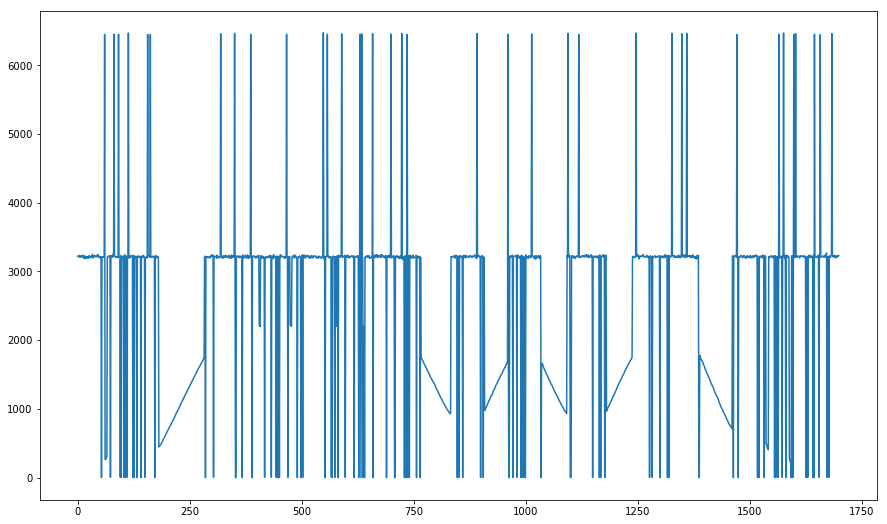

In [36]:
filepath = "LIDAR_100ms_Wander.csv"
with open(filepath, "r") as f:
    raw_data = [int(v) for v in f.read().split("\n") if v]

plt.plot(raw_data)
plt.show()

**a. Calculate probability of out of range measurements given that max is 40m == 4000cm**
    - Isolate readings greater than max range, and obtain their share from the total

In [37]:
max_range = 4000
out_of_range = [v for v in raw_data if v > max_range]
prob_out_of_range = len(out_of_range) * 100 / len(raw_data)
print("Probability of out of range measurement: {:2.2f}%".format(prob_out_of_range))

Probability of out of range measurement: 2.12%


**b. Calculate probability of suspiciously minimum range measurements given that min is 5cm**
    - Do the same thing for the minimum readings

In [38]:
min_range = 5
too_small = [v for v in raw_data if v < min_range]
prob_too_small = len(too_small) * 100 / len(raw_data)
print("Probability of suspiciously minimum range measurement: {:2.2f}%".format(prob_too_small))
too_small = [v for v in raw_data if v <= min_range]
prob_too_small = len(too_small) * 100 / len(raw_data)
print("Probability of suspiciously minimum range measurement when counting 5 as error: {:2.2f}%".format(prob_too_small))

Probability of suspiciously minimum range measurement: 4.00%
Probability of suspiciously minimum range measurement when counting 5 as error: 5.94%


**c. Sort out the wall measurements**

In order to sort them out lets look at the cleaned up graph of data against time. Clean up by removing erroneous minimum and maximum readings.

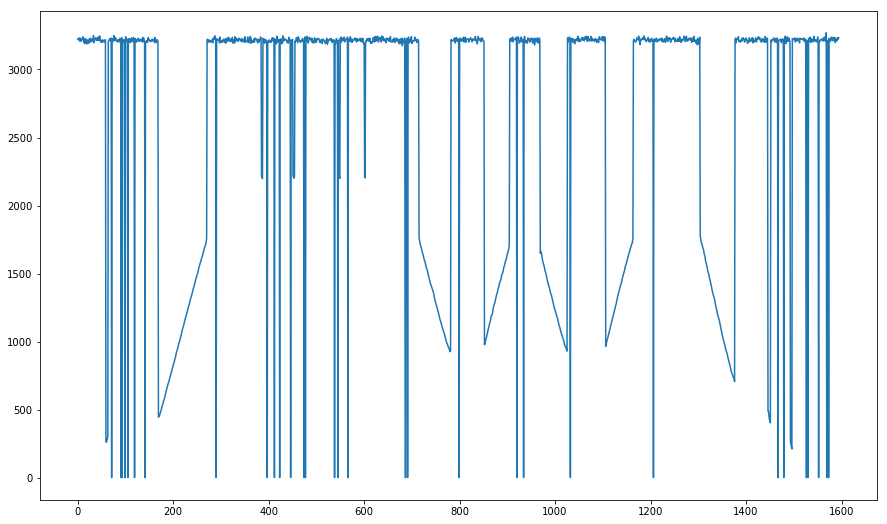

In [39]:
clean_data = [v for v in raw_data if (v >= min_range and v <= max_range)]
plt.plot(clean_data)
plt.show()

It looks like the wall readings are located over 3000cm mark, lets isolate them. This time working only with clean data.

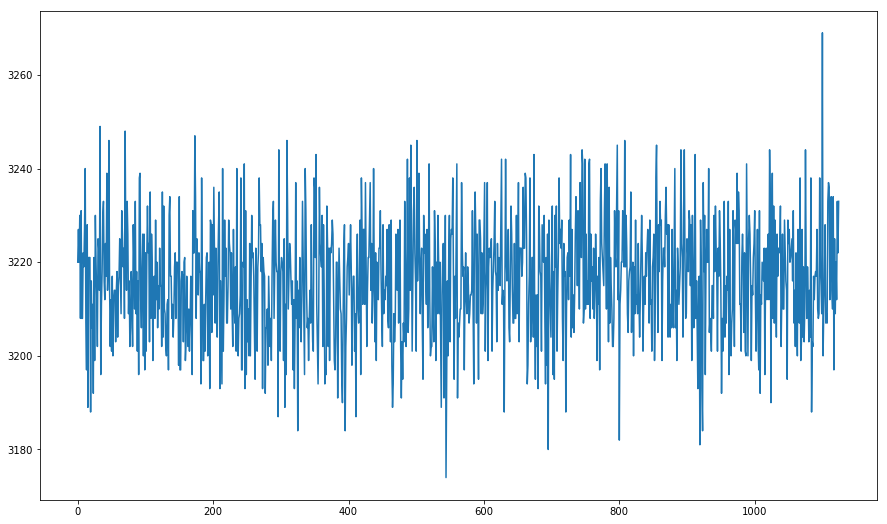

In [40]:
wall_threshold = 3000
wall_readings = [v for v in clean_data if v > wall_threshold]
plt.plot(wall_readings)
plt.show()

Now that all the wall readings had been isolated we can calculate the mean and stddev.

In [41]:
wall_mean = np.mean(wall_readings)
wall_stddev = np.std(wall_readings)
print("Wall mean {:4.2f}cm and stddev {:3.2f}cm".format(wall_mean, wall_stddev))

Wall mean 3216.19cm and stddev 12.62cm


**d. Find "objects" in the environment**

    i. How many "objects" are detected?
        - If we calculate the mean and variance of wall readings we can use that information to isolate non-wall readings
          Any value that is below the (mean - wall_variance) is not a wall reading

In [42]:
wall_variance = wall_stddev**2
print("Wall variance: {:3.2f}cm".format(wall_variance))

Wall variance: 159.34cm


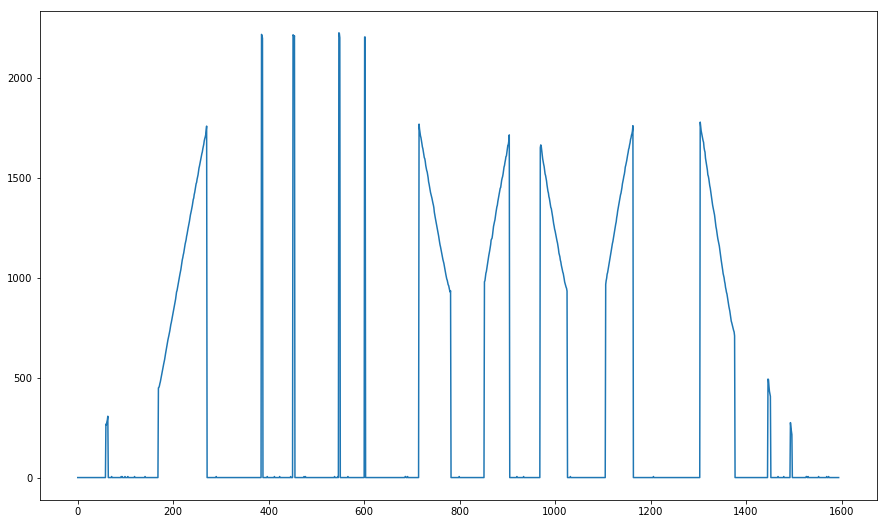

In [43]:
objects = [v if (v < wall_mean - wall_variance) else 0 for v in clean_data]
plt.plot(objects)
plt.show()

This provides us with every reading that is not a wall. Taking a naive approach one could simply count the non-zero values as peaks.

In [44]:
def naive_peaks(y, threshold=1):
    num_objects = 0
    up = False
    for i in range(0, len(objects)):
        if not up and objects[i] > threshold:
            num_objects += 1
            up = True
        elif up and objects[i] == 0:
            up = False
    return num_objects

min_reads = len([v for v in objects if v == 5])
print("Number of objects, naive approach: {}, min_reads: {}".format(naive_peaks(objects), min_reads))

Number of objects, naive approach: 44, min_reads: 33


The code above also shows how many "objects" are represented by a minimum read value of 5. Knowing that the sensor is aimed at a stationary wall it is safe to conclude that those minimum readings are a measurement error, and can be discared:

Number of objects, no minimum reads: 13


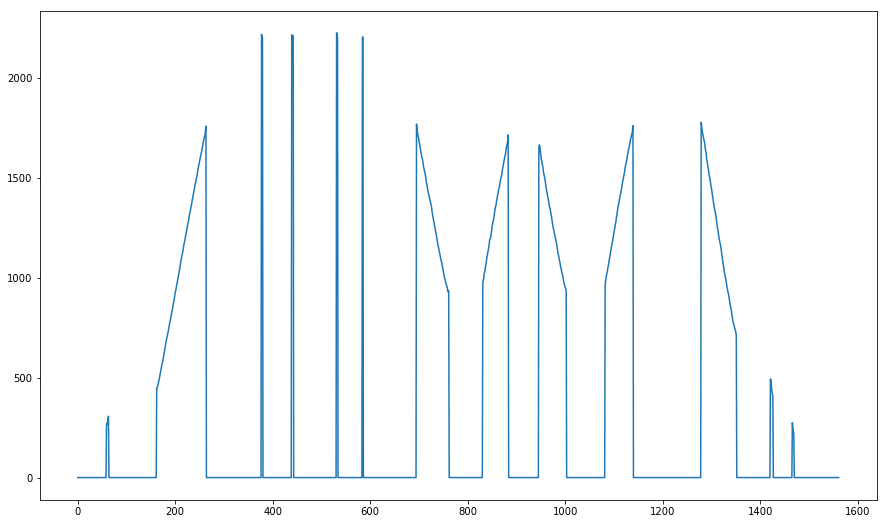

In [45]:
print("Number of objects, no minimum reads: {}".format(naive_peaks(objects, threshold=min_range)))
no_min_reads = [v for v in objects if v != min_range]
plt.plot(no_min_reads)
plt.show()

Graph above shows some very thin "objects". If looked at as time slices those objects were in view less than one second. Discarding them in favor of objects that were in view longer to calculate velocity. In this case using an algorithm to detect objects that must satisfy certain criteria of "height" and "width":

In [73]:
def windowed_peaks(y, threshold=1, window=10):
    up = False
    up_count = 0
    peaks = []
    cur_peak = []
    for i, value in enumerate(objects):
        if not up and value >= threshold:
            up_count += 1
            cur_peak.append(i)
            up = True
        elif up and value == 0:
            up = False
            if up_count >= window:
                peaks.append(cur_peak)
            up_count = 0
            cur_peak = []
        if up:
            up_count += 1
            cur_peak.append(i)
    return peaks

long_peaks = windowed_peaks(objects, threshold=6)
print("Number of long objects: {}".format(len(long_peaks)))

Number of long objects: 6


ii. What is the maximum velocity of an object? 
    - Given the detected objects one can calculate the velocity by looking at ratio of distance/time

In [75]:
dt = 0.1
def max_velocity(array):
    max_vel = 0
    readings = [objects[i] for i in array]
    distance = abs(max(readings)-min(readings)) # This is safe to do only because of the current data, and how it looks
    time = len(array) * dt
    velocity = distance / time
    return velocity

max_object_velocity = 0
for p in long_peaks:
    max_object_velocity = max(max_object_velocity, max_velocity(p))

print("Max object velocity: {} cm/s".format(max_object_velocity))

Max object velocity: 144.59459459459458 cm/s


iii. What is the probability that a given measurement is an object and not the wall?
    - Given detected objects one can find ratio of object_reading/all_readings to find the probability of object reading

In [66]:
import itertools

naive_objects = windowed_peaks(objects, threshold=1, window=1)
total_naive_readings = [v for v in itertools.chain.from_iterable(naive_objects)]

naive_probability = len(total_naive_readings) * 100 / len(raw_data)
print("Naive object probability: {:2.2f}%".format(naive_probability))

no_min_readings_objects = windowed_peaks(objects, threshold=6, window=1)
total_no_min_readings = [v for v in itertools.chain.from_iterable(no_min_readings_objects)]
no_min_read_prob = len(total_no_min_readings) * 100 / len(raw_data)
print("No min reading objects probability: {:2.2f}%".format(no_min_read_prob))

clean_objects = windowed_peaks(objects, threshold=6)
clean_readings = [v for v in itertools.chain.from_iterable(clean_objects)]
clean_prob = len(clean_readings) * 100 / len(raw_data)
print("Clean readings objects probability: {:2.2f}%".format(clean_prob))

Naive object probability: 30.25%
No min reading objects probability: 26.49%
Clean readings objects probability: 24.48%


### What is the pseudo-distribution (mixture distribution) for this range data?

First define the model then write the EM algorithm to establish priors.

Target priors: (0.0594467333725721, 0.6621542083578575, 0.2448499117127722, 0.02118893466745144, 0.012360211889346696)
Loops: 3
Pseudo distribution PF parameters.
Min reads: 0.059302310380738514, Wall: 0.658628282721504, Obj: 0.2608804722303059, Max: 0.02118893466745144, Noise: 0.2, Sigma: 159.32783108160604, Lambda: 0.0007867469187066738


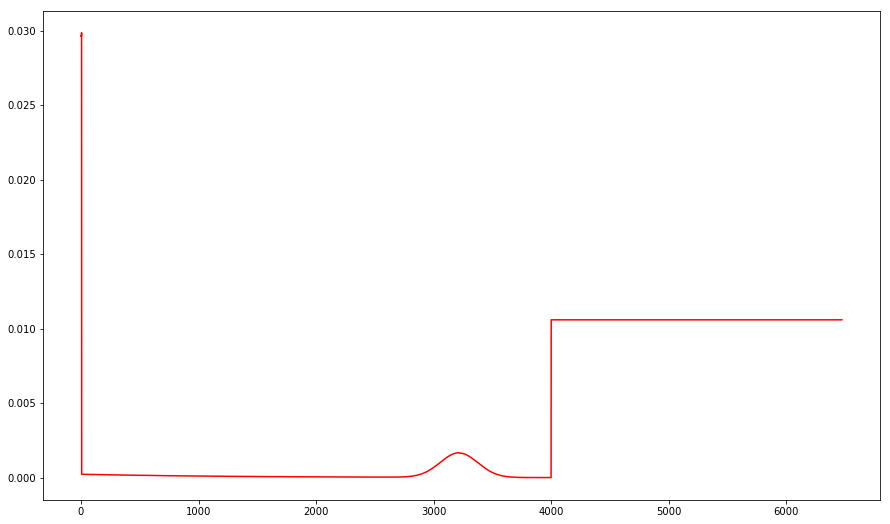

In [67]:
import functools
from scipy.stats import norm

def gaussian(x, mu, sig):
    return (1/(np.sqrt(2 * np.pi * np.power(sig, 2.)))) * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


p0_prior = len(too_small) / len(raw_data)
p1_prior = len(wall_readings) / len(raw_data)
p2_prior = len(clean_readings) / len(raw_data)
p3_prior = len(out_of_range) / len(raw_data)
p4_prior = 1 - p0_prior - p1_prior - p2_prior - p3_prior


def min_range_pdf(z, c_min):
    if 0 <= z <= min_range:
        return .5 * c_min
    return 0.0


def wall_range_pdf(z, mean, deviation, c_wall):
    if min_range < z < max_range:
        return gaussian(z, mean, deviation) * c_wall
    return 0.0


def object_range_pdf(z, lamb, z_max, c_obj):
    if min_range <= z <= z_max:
        nu = 1 / (1.0 - np.exp(-lamb * z_max))
        return nu * lamb * np.exp(-lamb * z) * c_obj
    return 0.0


def max_range_pdf(z, c_max):
    if z >= max_range:
        return .5 * c_max
    return 0.0


def noise_pdf(z, c_noise):
    if min_range <= z <= max_range:
        return c_noise/max_range
    return 0.0

print("Target priors: {}".format((p0_prior, p1_prior, p2_prior, p3_prior, p4_prior)))

def make_mixture(c_min, c_wall, c_obj, c_max, c_noise, sigma, lamb):
    p0 = functools.partial(min_range_pdf, c_min=c_min)
    p1 = functools.partial(wall_range_pdf, mean=wall_mean, deviation=sigma, c_wall=c_wall)
    p2 = functools.partial(object_range_pdf, lamb=lamb, z_max=wall_mean, c_obj=c_obj)
    p3 = functools.partial(max_range_pdf, c_max=c_max)
    p4 = functools.partial(noise_pdf, c_noise=c_noise)
    
    def mixture(z):
        return p0(z)+p1(z)+p2(z)+p3(z) #+p4(z)
    
    return mixture, p0, p1, p2, p3, p4


def EM(Z):    
    c_min, c_wall, c_obj, c_max, c_noise = (0.2,) * 5 #p0_prior, p1_prior, p2_prior, p3_prior, p4_prior
    c_min_prev, c_wall_prev, c_obj_prev, c_max_prev, c_noise_prev = (None,) * 5

    sigma = 10
    lamb = 0.0005
    sigma_prev = None
    lamb_prev = None
    
    loop = 0
    max_loops = 100

    mixture, p0, p1, p2, p3, p4 = make_mixture(c_min, c_wall, c_obj, c_max, c_noise, sigma, lamb)

    def stop_condition(new_cs, old_cs, new_sigma, old_sigma, new_lamb, old_lamb):
        if any(c is None for c in old_cs):
            return False

        c_diff = (abs(new_c - old_c) for new_c, old_c in zip(new_cs, old_cs))
        thresholds = (c * 0.01 for c in new_cs)
        cs_are_stable = all(diff < t for diff, t in zip(c_diff, thresholds))
        
        sigma_stable = np.abs(np.power(new_sigma, 2) - np.power(old_sigma, 2)) < (0.01 * new_sigma * new_sigma)
        lambda_stable = np.abs(new_lamb - old_lamb) < (0.01* new_lamb)

        #print("old cs: {}".format(old_cs))
        #print("new cs: {}".format(new_cs))
        #print("cs stable: {}, sigma stable: {}, lambda stable: {}".format(cs_are_stable, sigma_stable, lambda_stable))
        
        return cs_are_stable and sigma_stable and lambda_stable


    while loop < max_loops and not stop_condition((c_wall, c_obj, c_max, c_noise, c_min), 
                                                  (c_wall_prev, c_obj_prev, c_max_prev, c_noise_prev, c_min_prev),
                                                  sigma,
                                                  sigma_prev,
                                                  lamb,
                                                  lamb_prev):
        e_min = []
        e_wall = []
        e_obj = []
        e_max = []
        e_noise = []
        for i, z in enumerate(Z):
            try:
                nu = 1 / mixture(z)

                e_min.append(nu * p0(z))
                e_wall.append(nu * p1(z))
#                if wall_mean <= z < max_range:
#                    e_wall[-1] = 1
                e_obj.append(nu * p2(z))
                e_max.append(nu * p3(z))
                e_noise.append(nu * p4(z))
            except ZeroDivisionError:
                print("Error Value: {}".format(z))
                return None

        c_min_prev = c_min
        c_wall_prev = c_wall
        c_obj_prev = c_obj
        c_max_prev = c_max
        c_noise_prev = c_noise
        sigma_prev = sigma
        lamb_prev = lamb

        e_wall_sum = np.sum(e_wall)
        e_obj_sum = np.sum(e_obj)

        c_wall = np.sum(e_wall) / len(Z)
        c_obj = np.sum(e_obj) / len(Z)
        c_max = np.sum(e_max) / len(Z)
#        c_noise = np.sum(e_noise) / len(Z)
        c_min = np.sum(e_min) / len(Z)
        
        sigma = np.sum(e_v * (z - wall_mean)**2 for e_v, z in zip(e_wall, Z)) / e_wall_sum
        lamb = e_obj_sum / np.sum(e_v * z for e_v, z in zip(e_obj, Z))

        # attach new values of cs, stddev and lambda
        mixture, p0, p1, p2, p3, p4 = make_mixture(c_min, c_wall, c_obj, c_max, c_noise, sigma, lamb)
        loop += 1

    print("Loops: {}".format(loop))
    return (c_min, c_wall, c_obj, c_max, c_noise, sigma, lamb)

params = EM(np.array(raw_data))

print("Pseudo distribution PF parameters.\nMin reads: {}, Wall: {}, Obj: {}, Max: {}, Noise: {}, Sigma: {}, Lambda: {}"
      .format(*params))
mixture, *_ = make_mixture(*params)

histo = [0] * (max(raw_data)+1)
for datum in raw_data:
    histo[datum] += 1

norm_hist = histo / np.max(histo)

wall_gauss = np.array([mixture(v) for v in range(max(raw_data))]) 

#plt.plot(histo)
plt.plot(wall_gauss, color='red')
plt.show()

The picture above shows the model captures the given data set.